## Energy loss and momentum broadening in cold QCD matter

## Import and Preprocess

In [1]:
# ================================
# eLoss-only notebook (publication styling)
# ================================
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path

# -- modules --
sys.path.append("./code")
from eloss_module import load_eloss_run          # (we only need this)
from npdf_module import centers_to_left_edges    # simple helper for step edges
from npdf_module import WoodsSaxonPb, CentralityModel  # for optional <Ncoll>

# ---------- I/O: edit these ----------
BASE8 = "./input/eloss/pPb8TeV/output_8160GeV_pPb_alpha_constant"
BASE5 = "./input/eloss/pPb5TeV/output_5023GeV_pPb_alpha_constant"
# BASE8 = "./input/eloss/pPb8TeV/output_8160GeV_pPb_alpha_running"
# BASE5 = "./input/eloss/pPb5TeV/output_5023GeV_pPb_alpha_running"
outdir = Path("./output-eloss-comparisons"); outdir.mkdir(exist_ok=True)

# √s-dependent σ_NN (mb) for N_coll tables (optional)
sigma5, sigma8 = 67.0, 71.0

# ---------- style ----------
plt.rcParams.update({
    "figure.dpi": 130, "font.size": 12,
    "axes.grid": False,          # no grid by default
    "axes.spines.top": True,     # show top/right frames (no ticks)
    "axes.spines.right": True,
})

def _cosmetics(ax):
    for s in ax.spines.values():
        s.set_visible(True)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="y", which="minor", length=3, width=0.8)
    ax.tick_params(axis="y", which="major", length=5, width=1.0)
    ax.grid(False)

# ---------- load runs (robust: OK if one is missing) ----------
try:
    run8 = load_eloss_run(BASE8, log_level=20, choose=["output_qhat0_0.051","output_qhat0_0.09"])
except Exception:
    run8 = None
try:
    run5 = load_eloss_run(BASE5, log_level=20, choose=["output_qhat0_0.051","output_qhat0_0.09"])
except Exception:
    run5 = None
assert (run5 is not None) or (run8 is not None), "No eLoss runs found. Check BASE paths."

[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100
[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100
[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100
[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100


In [2]:
# analysis windows (edit as needed)
CENT_EDGES = [0,20,40,60,80,100]      # centrality bins (%)
Y_RANGES   = [(-4.46,-2.96), (2.03,3.53)]  # BACK, FOR example
PT_RANGE   = (0.0, 20.0)
outdir   = Path("./output-eloss-comparisons"); outdir.mkdir(exist_ok=True)

# centrality edges (prefer from a present run)
CENT_EDGES = (run5 or run8).centrality_edges if hasattr((run5 or run8), "centrality_edges") else [0,20,40,60,80,100]
PT_RANGE   = (0.0, 20.0)  # default
Y_THREE    = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]  # Back | Mid | For

# ---------- tiny helpers ----------
BAND_COLOR       =  "#ff7f0e"
ELOSS_COLOR      =  "#ff7f0e"
LS_5, LS_8        = "-", "--"
BAND_ALPHA_SOLID  = 0.35
HATCH_8           = "////"

In [3]:
## Helper functions

def _ensure_dir(pathlike):
    p = Path(pathlike); p.parent.mkdir(parents=True, exist_ok=True); return p

def _save_or_show(fig, save):
    if save is not None:
        p = _ensure_dir(save)
        fig.set_constrained_layout(False)
        fig.tight_layout()
        fig.savefig(p, dpi=300, bbox_inches="tight", pad_inches=0.02, facecolor="white")
        print(f"Saved: {p}")
        plt.close(fig)
    else:
        fig.tight_layout()
        plt.show()

def _cent_labels(edges):
    return [f"{edges[i]}-{edges[i+1]}%" for i in range(len(edges)-1)]

def _norm_cent(s):
    s = str(s).replace("–","-").replace("%","").strip()
    a,b = [float(x) for x in s.split("-")]
    f = lambda x: (str(int(round(x))) if abs(x-round(x))<1e-8 else f"{x:g}")
    return f"{f(a)}-{f(b)}%"

def _best_match_tag(run, label):
    want = _norm_cent(label)
    pool = [(t if "%" in t else f"{t}%") for t in run.available_cent_tags]
    def ov(a,b):
        (aL,aR) = [float(x) for x in a.replace("%","").split("-")]
        (bL,bR) = [float(x) for x in b.replace("%","").split("-")]
        return max(0., min(aR,bR) - max(aL,bL))
    if want in pool: return want.replace("%","")
    return max(pool, key=lambda t: ov(want,t)).replace("%","")

def as_step(edges, vals):
    e = np.asarray(edges, float)
    v = np.asarray(vals,  float)
    return e, np.r_[v, v[-1]]

def _cent_box(ax, text, xy=(0.02, 0.96)):
    ax.text(xy[0], xy[1], text, transform=ax.transAxes, ha="left", va="top",
            fontsize=10, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))

def _kine_box(ax, lines, xy=(0.02, 0.04)):
    ax.text(xy[0], xy[1], "\n".join(lines), transform=ax.transAxes, ha="left", va="bottom",
            fontsize=10, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))

def _plot_solid_band(ax, X, L, H, C, *, label):
    ax.fill_between(X, L, H, step="post", facecolor=ELOSS_COLOR, edgecolor=ELOSS_COLOR,
                    alpha=BAND_ALPHA_SOLID, zorder=2.0)
    line, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=ELOSS_COLOR, linestyle=LS_5,
                    label=label, zorder=3.0)
    return line

def _plot_hatched_band(ax, X, L, H, C, *, label):
    ax.fill_between(X, L, H, step="post", facecolor="none", edgecolor=ELOSS_COLOR,
                    hatch=HATCH_8, linewidth=0.8, zorder=3.0)
    line, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=ELOSS_COLOR, linestyle=LS_8,
                    label=label, zorder=3.1)
    return line

# ---------- eLoss “data access” ----------
def eloss_band_over_range(run, cent_label, y_range, pt_range):
    """Return (c, lo, hi) for a centrality bin averaged over y×pT; works for ensemble or single run."""
    if run is None: return None
    tag = _best_match_tag(run, cent_label)
    try:
        c  = float(run.mean_rpa_over_y_and_pt(tag, y_range, pt_range))
        hw = float(run.mean_rpa_err_over_y_and_pt(tag, y_range, pt_range))   # half-width (if ensemble)
        return c, c - hw, c + hw
    except Exception:
        # fallback (single run): average its y-curve
        y_edges = np.arange(y_range[0], y_range[1] + 1e-12, 0.5)
        df = run.rpa_vs_y(cent_tag=tag, y_edges=y_edges, pt_range=pt_range)
        c  = float(np.nanmean(np.asarray(df.get("RpA", df.get("c")))))
        lo = float(np.nanmin(np.asarray(df.get("lo", np.array([c])))))
        hi = float(np.nanmax(np.asarray(df.get("hi", np.array([c])))))
        return c, lo, hi

def eloss_table_vs_centrality(run, cent_edges, y_range, pt_range):
    rows = []
    for lab in _cent_labels(cent_edges):
        c, lo, hi = eloss_band_over_range(run, lab, y_range, pt_range)
        rows.append(dict(cent_bin=_norm_cent(lab), r_central=c, r_lo=lo, r_hi=hi))
    return pd.DataFrame(rows)

def eloss_y_band_in_cent(run, cent_label, y_width, pt_range):
    tag = _best_match_tag(run, cent_label)
    y_edges = np.arange(-5.0, 5.0 + 1e-12, float(y_width))
    df = run.rpa_vs_y(cent_tag=tag, y_edges=y_edges, pt_range=pt_range).copy()
    df.rename(columns={"y_mid":"y", "RpA":"c"}, inplace=True)
    if "lo" not in df: df["lo"] = df["c"]
    if "hi" not in df: df["hi"] = df["c"]
    edges = centers_to_left_edges(df["y"].to_numpy(float), width=float(y_width))
    return edges, df["c"].to_numpy(float), df["lo"].to_numpy(float), df["hi"].to_numpy(float)

def eloss_pt_band_in_cent(run, cent_label, y_range, pt_width):
    tag = _best_match_tag(run, cent_label)
    pt_edges = np.arange(0.0, 20.0 + 1e-12, float(pt_width))
    df = run.rpa_vs_pt(cent_tag=tag, y_range=y_range, pt_edges=pt_edges).copy()
    df.rename(columns={"pt_mid":"pt", "RpA":"c"}, inplace=True)
    if "lo" not in df: df["lo"] = df["c"]
    if "hi" not in df: df["hi"] = df["c"]
    edges = centers_to_left_edges(df["pt"].to_numpy(float), width=float(pt_width))
    return edges, df["c"].to_numpy(float), df["lo"].to_numpy(float), df["hi"].to_numpy(float)

# ---------- optional: geometry-only centrality model for <Ncoll> ----------
def make_geom_model():
    geom = WoodsSaxonPb()
    T = geom.make_T_grid(b_max=12.0, nb=601)
    Nnorm = geom.normalization_N(T)
    # CentralityModel is a dataclass; we won't use 'gluon' here
    return CentralityModel(gluon=None, geom=geom, T_grid=T, Nnorm=Nnorm, _pdf_cache=None, _alpha_cache={})

cm_geom = make_geom_model()  # single geometry model is enough (sigma passed at call-time)

## $R_{pA}$ vs Centrality

In [4]:
# =========================================================
# 1) Three-panel: RpA vs centrality (%) or vs <Ncoll>
# =========================================================
def eloss_threepanel_centrality(*,
        run5=None, run8=None, xmode="centrality",
        cent_edges=CENT_EDGES, pt_range=PT_RANGE,
        y_ranges_three=Y_THREE, ylim=(0.5,1.4),
        legend_loc="lower right", save=None,
        cm=cm_geom, sigma5=sigma5, sigma8=sigma8
    ):
    assert (run5 is not None) or (run8 is not None)
    fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.2), sharey=True, constrained_layout=True)

    for ax, y_rng in zip(axes, y_ranges_three):
        t5 = eloss_table_vs_centrality(run5, cent_edges, y_rng, pt_range) if run5 else None
        t8 = eloss_table_vs_centrality(run8, cent_edges, y_rng, pt_range) if run8 else None
        lines = []

        if xmode.lower() == "centrality":
            X = np.asarray(cent_edges, float)

            if (t5 is not None) and len(t5):
                _, C = as_step(cent_edges, t5["r_central"]); _, L = as_step(cent_edges, t5["r_lo"]); _, H = as_step(cent_edges, t5["r_hi"])
                lines.append(_plot_solid_band(ax, X, L, H, C, label="5.02 TeV"))

            if (t8 is not None) and len(t8):
                _, C = as_step(cent_edges, t8["r_central"]); _, L = as_step(cent_edges, t8["r_lo"]); _, H = as_step(cent_edges, t8["r_hi"])
                if run5 is not None:
                    lines.append(_plot_hatched_band(ax, X, L, H, C, label="8.16 TeV"))
                else:
                    lines.append(_plot_solid_band(ax,   X, L, H, C, label="8.16 TeV"))

            ax.set_xlabel("Centrality [%]")
            ax.set_xticks(cent_edges); ax.set_xlim(0, 100)

        else:  # x = <Ncoll>
            assert cm is not None, "Need a centrality model (cm) for <Ncoll>."
            # build x arrays with the right σ_NN for each energy
            if run5 and t5 is not None and len(t5):
                ctab5 = cm.centrality_table(cent_edges, sigmaNN_mb=sigma5)
                x5 = np.asarray(ctab5["N_coll"], float); o5 = np.argsort(x5); x5=x5[o5]
                c5 = t5["r_central"].to_numpy(float)[o5]; l5=t5["r_lo"].to_numpy(float)[o5]; h5=t5["r_hi"].to_numpy(float)[o5]
                ax.fill_between(x5, l5, h5, facecolor=ELOSS_COLOR, edgecolor=ELOSS_COLOR, alpha=BAND_ALPHA_SOLID, zorder=2.0)
                line5, = ax.plot(x5, c5, lw=2, color=ELOSS_COLOR, linestyle=LS_5, marker="o", ms=4, label="5.02 TeV", zorder=3.0)
                lines.append(line5)

            if run8 and t8 is not None and len(t8):
                ctab8 = cm.centrality_table(cent_edges, sigmaNN_mb=sigma8)
                x8 = np.asarray(ctab8["N_coll"], float); o8 = np.argsort(x8); x8=x8[o8]
                c8 = t8["r_central"].to_numpy(float)[o8]; l8=t8["r_lo"].to_numpy(float)[o8]; h8=t8["r_hi"].to_numpy(float)[o8]
                if run5:
                    ax.fill_between(x8, l8, h8, facecolor="none", edgecolor=ELOSS_COLOR, hatch=HATCH_8, linewidth=0.8, zorder=3.0)
                    line8, = ax.plot(x8, c8, lw=2, color=ELOSS_COLOR, linestyle=LS_8, marker="s", ms=4, label="8.16 TeV", zorder=3.1)
                else:
                    ax.fill_between(x8, l8, h8, facecolor=ELOSS_COLOR, edgecolor=ELOSS_COLOR, alpha=BAND_ALPHA_SOLID, zorder=2.0)
                    line8, = ax.plot(x8, c8, lw=2, color=ELOSS_COLOR, linestyle=LS_5, marker="s", ms=4, label="8.16 TeV", zorder=3.1)
                lines.append(line8)

            ax.set_xlabel(r"$\langle N_{\mathrm{coll}}\rangle$")

        ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
        _kine_box(ax, [f"{y_rng[0]:.2f} < $y$ < {y_rng[1]:.2f}",
                       f"{pt_range[0]:.1f} < $p_T$ < {pt_range[1]:.1f} GeV"])
        _cosmetics(ax)
        if lines:
            ax.legend(handles=lines, frameon=False, loc=legend_loc, borderaxespad=0.6)
    plt.show()
    _save_or_show(fig, save)

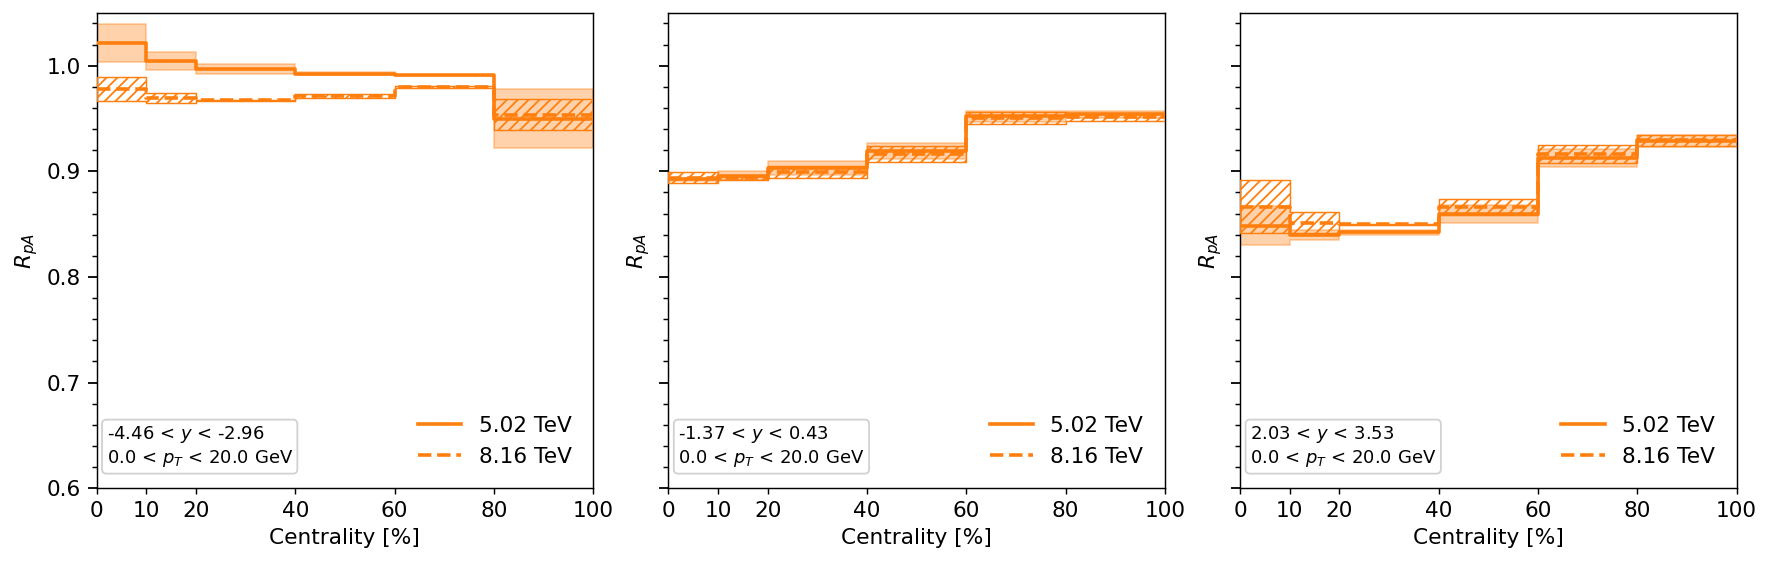

Saved: output-eloss-comparisons/eloss_RpA_vs_centrality_BACK_MID_FOR_5v8.pdf


In [5]:
# =========================
# Centrality (%)
# =========================
eloss_threepanel_centrality(
    run5=run5, run8=run8, xmode="centrality",
    cent_edges=CENT_EDGES, pt_range=PT_RANGE,
    y_ranges_three=Y_THREE, ylim=(0.60,1.05),
    save=outdir/"eloss_RpA_vs_centrality_BACK_MID_FOR_5v8.pdf"
)

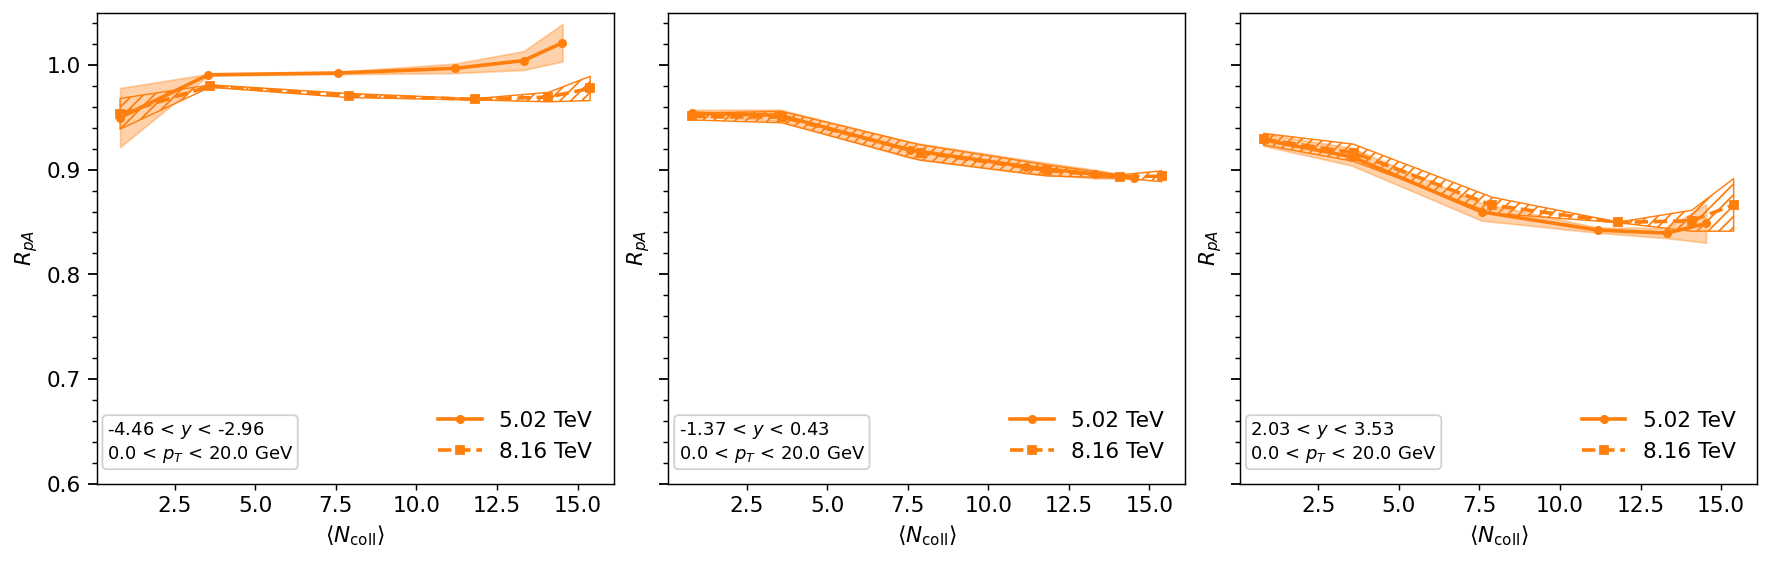

Saved: output-eloss-comparisons/eloss_RpA_vs_Ncoll_BACK_MID_FOR_5v8.pdf


In [6]:
# <Ncoll> instead of %, keep geometry-only 'cm_geom' & σ_NN:
eloss_threepanel_centrality(
    run5=run5, run8=run8, xmode="ncoll",
    cent_edges=CENT_EDGES, pt_range=PT_RANGE,
    y_ranges_three=Y_THREE, ylim=(0.60,1.05),
    cm=cm_geom, sigma5=sigma5, sigma8=sigma8,
    save=outdir/"eloss_RpA_vs_Ncoll_BACK_MID_FOR_5v8.pdf"
)

## $R_{pA}$ vs Rapidity

In [7]:
# =========================
# RpA vs y  (grid of centrality bins)
# =========================
def eloss_rpa_vs_y_in_centbins(
    *, run5=None, run8=None, cent_edges,
    y_width=0.5, pt_range=(0.0, 20.0),
    ylim=(0.35, 1.40), ncols=3, save=None
):
    assert (run5 is not None) or (run8 is not None), "Need at least one eLoss run."

    labs = _cent_labels(cent_edges)
    n = len(labs); ncols = min(int(ncols), n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.8*nrows), sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        lines = []

        # ---- 5.02 TeV (solid) ----
        if run5 is not None:
            tag = _best_match_tag(run5, lab)
            y_edges = np.arange(-5.0, 5.0 + 1e-12, float(y_width))
            df5 = run5.rpa_vs_y(tag, y_edges=y_edges, pt_range=pt_range).copy()
            df5.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df5: df5["lo"] = df5["c"]
            if "hi" not in df5: df5["hi"] = df5["c"]

            X = np.r_[df5["y_left"], df5["y_right"].iloc[-1]]
            C = np.r_[df5["c"], df5["c"].iloc[-1]]
            L = np.r_[df5["lo"], df5["lo"].iloc[-1]]
            H = np.r_[df5["hi"], df5["hi"].iloc[-1]]
            lines.append(_plot_solid_band(ax, X, L, H, C, label="5.02 TeV"))

        # ---- 8.16 TeV (hatched if 5 is present; solid if alone) ----
        if run8 is not None:
            tag = _best_match_tag(run8, lab)
            y_edges = np.arange(-5.0, 5.0 + 1e-12, float(y_width))
            df8 = run8.rpa_vs_y(tag, y_edges=y_edges, pt_range=pt_range).copy()
            df8.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df8: df8["lo"] = df8["c"]
            if "hi" not in df8: df8["hi"] = df8["c"]

            X = np.r_[df8["y_left"], df8["y_right"].iloc[-1]]
            C = np.r_[df8["c"], df8["c"].iloc[-1]]
            L = np.r_[df8["lo"], df8["lo"].iloc[-1]]
            H = np.r_[df8["hi"], df8["hi"].iloc[-1]]
            if run5 is not None:
                lines.append(_plot_hatched_band(ax, X, L, H, C, label="8.16 TeV"))
            else:
                lines.append(_plot_solid_band(ax,   X, L, H, C, label="8.16 TeV"))

        # ---- cosmetics & notes ----
        ax.set_xlabel("y"); ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
        ax.set_xlim(-5.0, 5.0); ax.margins(x=0)
        _cent_box(ax, lab)  # centrality (top-left)
        _kine_box(ax, [fr"$\Delta y={y_width}$",
                       fr"{pt_range[0]:.1f} < $p_T$ < {pt_range[1]:.1f} GeV"])  # bottom-left
        _cosmetics(ax)
        if lines:
            ax.legend(handles=lines, frameon=False, loc="lower right", borderaxespad=0.6)

    for ax in axes[len(labs):]:  # hide empties
        ax.axis("off")

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()


# =========================
# RpA vs pT  (grid of centrality bins)
# =========================
def eloss_rpa_vs_pt_in_centbins(
    *, run5=None, run8=None, cent_edges,
    y_range=(-1.37, 0.43), pt_width=2.5,
    xlim=(0,20), ylim=(0.35,1.40), ncols=3, save=None
):
    assert (run5 is not None) or (run8 is not None), "Need at least one eLoss run."

    labs = _cent_labels(cent_edges)
    n = len(labs); ncols = min(int(ncols), n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.8*nrows), sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        lines = []

        # ---- 5.02 TeV (solid) ----
        if run5 is not None:
            tag = _best_match_tag(run5, lab)
            pt_edges = np.arange(float(xlim[0]), float(xlim[1]) + 1e-12, float(pt_width))
            df5 = run5.rpa_vs_pt(tag, y_range=y_range, pt_edges=pt_edges).copy()
            df5.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df5: df5["lo"] = df5["c"]
            if "hi" not in df5: df5["hi"] = df5["c"]

            X = np.r_[df5["pt_left"], df5["pt_right"].iloc[-1]]
            C = np.r_[df5["c"], df5["c"].iloc[-1]]
            L = np.r_[df5["lo"], df5["lo"].iloc[-1]]
            H = np.r_[df5["hi"], df5["hi"].iloc[-1]]
            lines.append(_plot_solid_band(ax, X, L, H, C, label="5.02 TeV"))

        # ---- 8.16 TeV (hatched if 5 present; solid if alone) ----
        if run8 is not None:
            tag = _best_match_tag(run8, lab)
            pt_edges = np.arange(float(xlim[0]), float(xlim[1]) + 1e-12, float(pt_width))
            df8 = run8.rpa_vs_pt(tag, y_range=y_range, pt_edges=pt_edges).copy()
            df8.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df8: df8["lo"] = df8["c"]
            if "hi" not in df8: df8["hi"] = df8["c"]

            X = np.r_[df8["pt_left"], df8["pt_right"].iloc[-1]]
            C = np.r_[df8["c"], df8["c"].iloc[-1]]
            L = np.r_[df8["lo"], df8["lo"].iloc[-1]]
            H = np.r_[df8["hi"], df8["hi"].iloc[-1]]
            if run5 is not None:
                lines.append(_plot_hatched_band(ax, X, L, H, C, label="8.16 TeV"))
            else:
                lines.append(_plot_solid_band(ax,   X, L, H, C, label="8.16 TeV"))

        # ---- cosmetics & notes ----
        ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(r"$R_{pA}$")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        _cent_box(ax, lab)  # centrality (top-left)
        _kine_box(ax, [fr"{y_range[0]:.2f} < $y$ < {y_range[1]:.2f}",
                       fr"$\Delta p_T={pt_width}$"])  # bottom-left
        _cosmetics(ax)
        if lines:
            ax.legend(handles=lines, frameon=False, loc="lower right", borderaxespad=0.6)

    for ax in axes[len(labs):]:
        ax.axis("off")

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

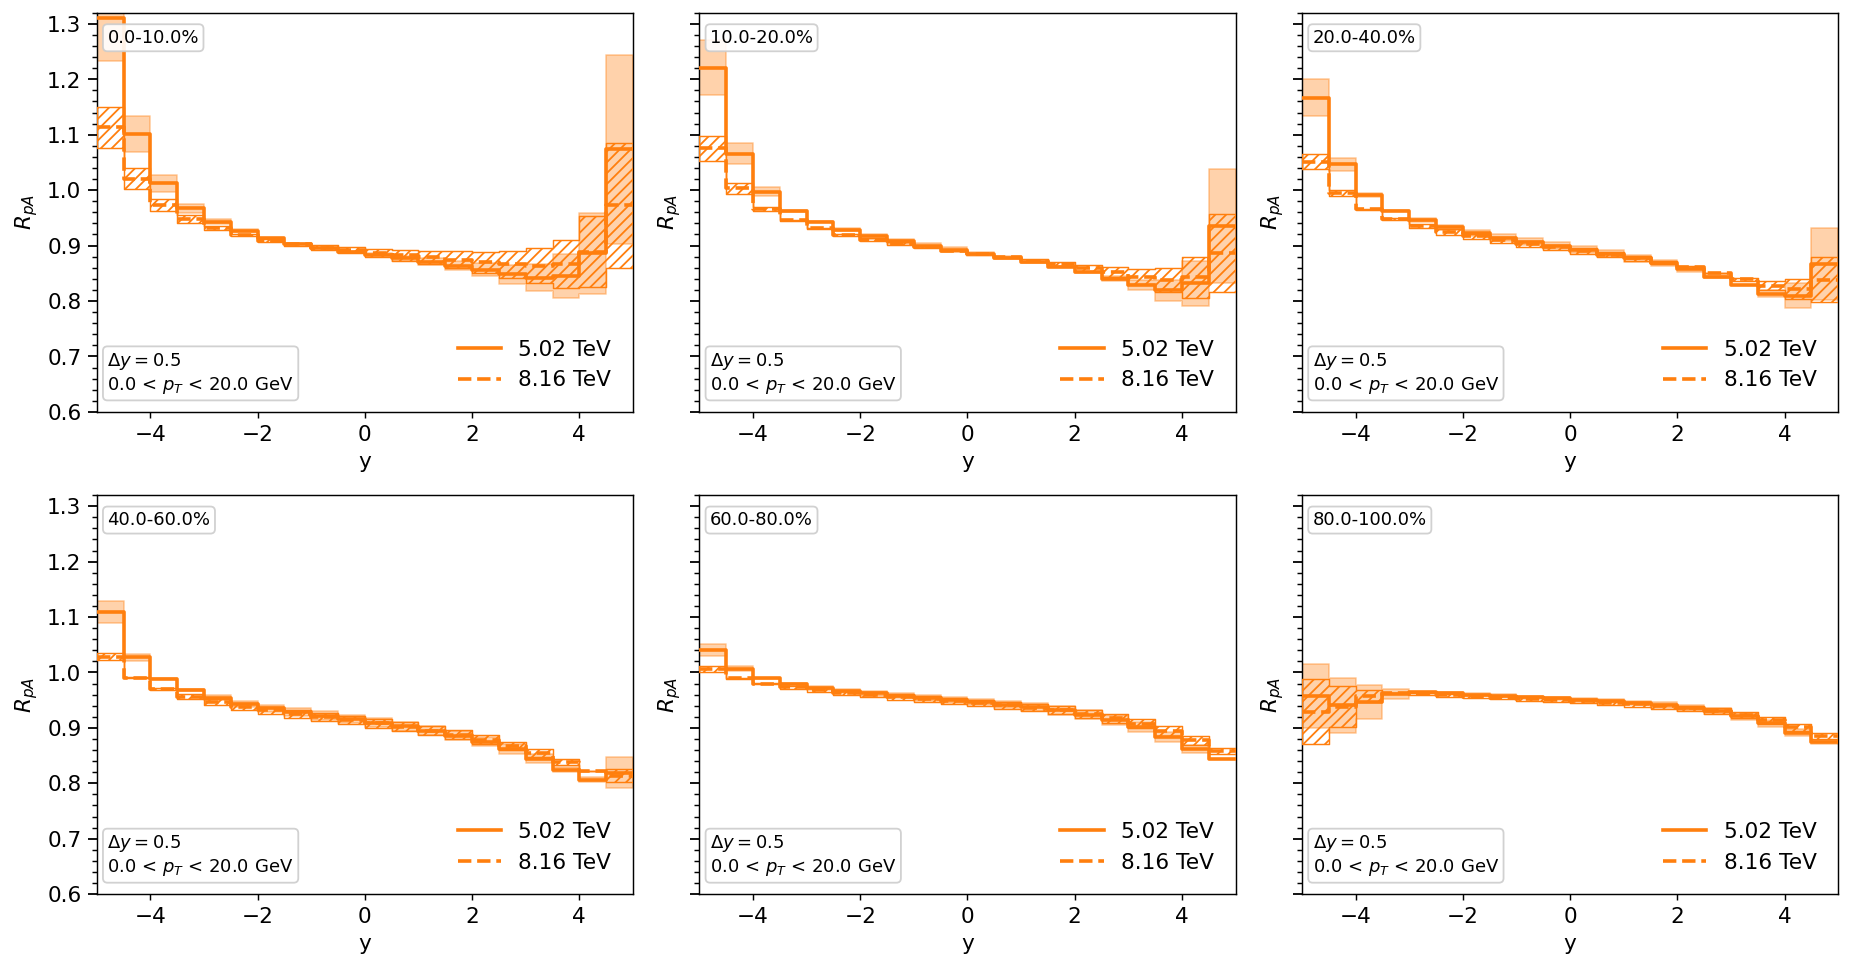

In [8]:
eloss_rpa_vs_y_in_centbins(
    run5=run5, run8=run8, cent_edges=CENT_EDGES,
    y_width=0.5, pt_range=PT_RANGE, ylim=(0.60,1.32), ncols=3,
    save=outdir/"eloss_RpA_vs_y_in_centbins_5v8.pdf"
)

## $R_{pA}$ vs Transverse Momentum

In [9]:
# =========================
# RpA vs pT  (grid of centrality bins)
# =========================
def eloss_rpa_vs_pt_in_centbins(
    *, run5=None, run8=None, cent_edges,
    y_range=(-1.37, 0.43), pt_width=2.5,
    xlim=(0,20), ylim=(0.35,1.40), ncols=3, save=None
):
    assert (run5 is not None) or (run8 is not None), "Need at least one eLoss run."

    labs = _cent_labels(cent_edges)
    n = len(labs); ncols = min(int(ncols), n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.8*nrows), sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        lines = []

        # ---- 5.02 TeV (solid) ----
        if run5 is not None:
            tag = _best_match_tag(run5, lab)
            pt_edges = np.arange(float(xlim[0]), float(xlim[1]) + 1e-12, float(pt_width))
            df5 = run5.rpa_vs_pt(tag, y_range=y_range, pt_edges=pt_edges).copy()
            df5.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df5: df5["lo"] = df5["c"]
            if "hi" not in df5: df5["hi"] = df5["c"]

            X = np.r_[df5["pt_left"], df5["pt_right"].iloc[-1]]
            C = np.r_[df5["c"], df5["c"].iloc[-1]]
            L = np.r_[df5["lo"], df5["lo"].iloc[-1]]
            H = np.r_[df5["hi"], df5["hi"].iloc[-1]]
            lines.append(_plot_solid_band(ax, X, L, H, C, label="5.02 TeV"))

        # ---- 8.16 TeV (hatched if 5 present; solid if alone) ----
        if run8 is not None:
            tag = _best_match_tag(run8, lab)
            pt_edges = np.arange(float(xlim[0]), float(xlim[1]) + 1e-12, float(pt_width))
            df8 = run8.rpa_vs_pt(tag, y_range=y_range, pt_edges=pt_edges).copy()
            df8.rename(columns={"RpA":"c"}, inplace=True)
            if "lo" not in df8: df8["lo"] = df8["c"]
            if "hi" not in df8: df8["hi"] = df8["c"]

            X = np.r_[df8["pt_left"], df8["pt_right"].iloc[-1]]
            C = np.r_[df8["c"], df8["c"].iloc[-1]]
            L = np.r_[df8["lo"], df8["lo"].iloc[-1]]
            H = np.r_[df8["hi"], df8["hi"].iloc[-1]]
            if run5 is not None:
                lines.append(_plot_hatched_band(ax, X, L, H, C, label="8.16 TeV"))
            else:
                lines.append(_plot_solid_band(ax,   X, L, H, C, label="8.16 TeV"))

        # ---- cosmetics & notes ----
        ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(r"$R_{pA}$")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        _cent_box(ax, lab)  # centrality (top-left)
        _kine_box(ax, [fr"{y_range[0]:.2f} < $y$ < {y_range[1]:.2f}",
                       fr"$\Delta p_T={pt_width}$"])  # bottom-left
        _cosmetics(ax)
        if lines:
            ax.legend(handles=lines, frameon=False, loc="lower right", borderaxespad=0.6)

    for ax in axes[len(labs):]:
        ax.axis("off")

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

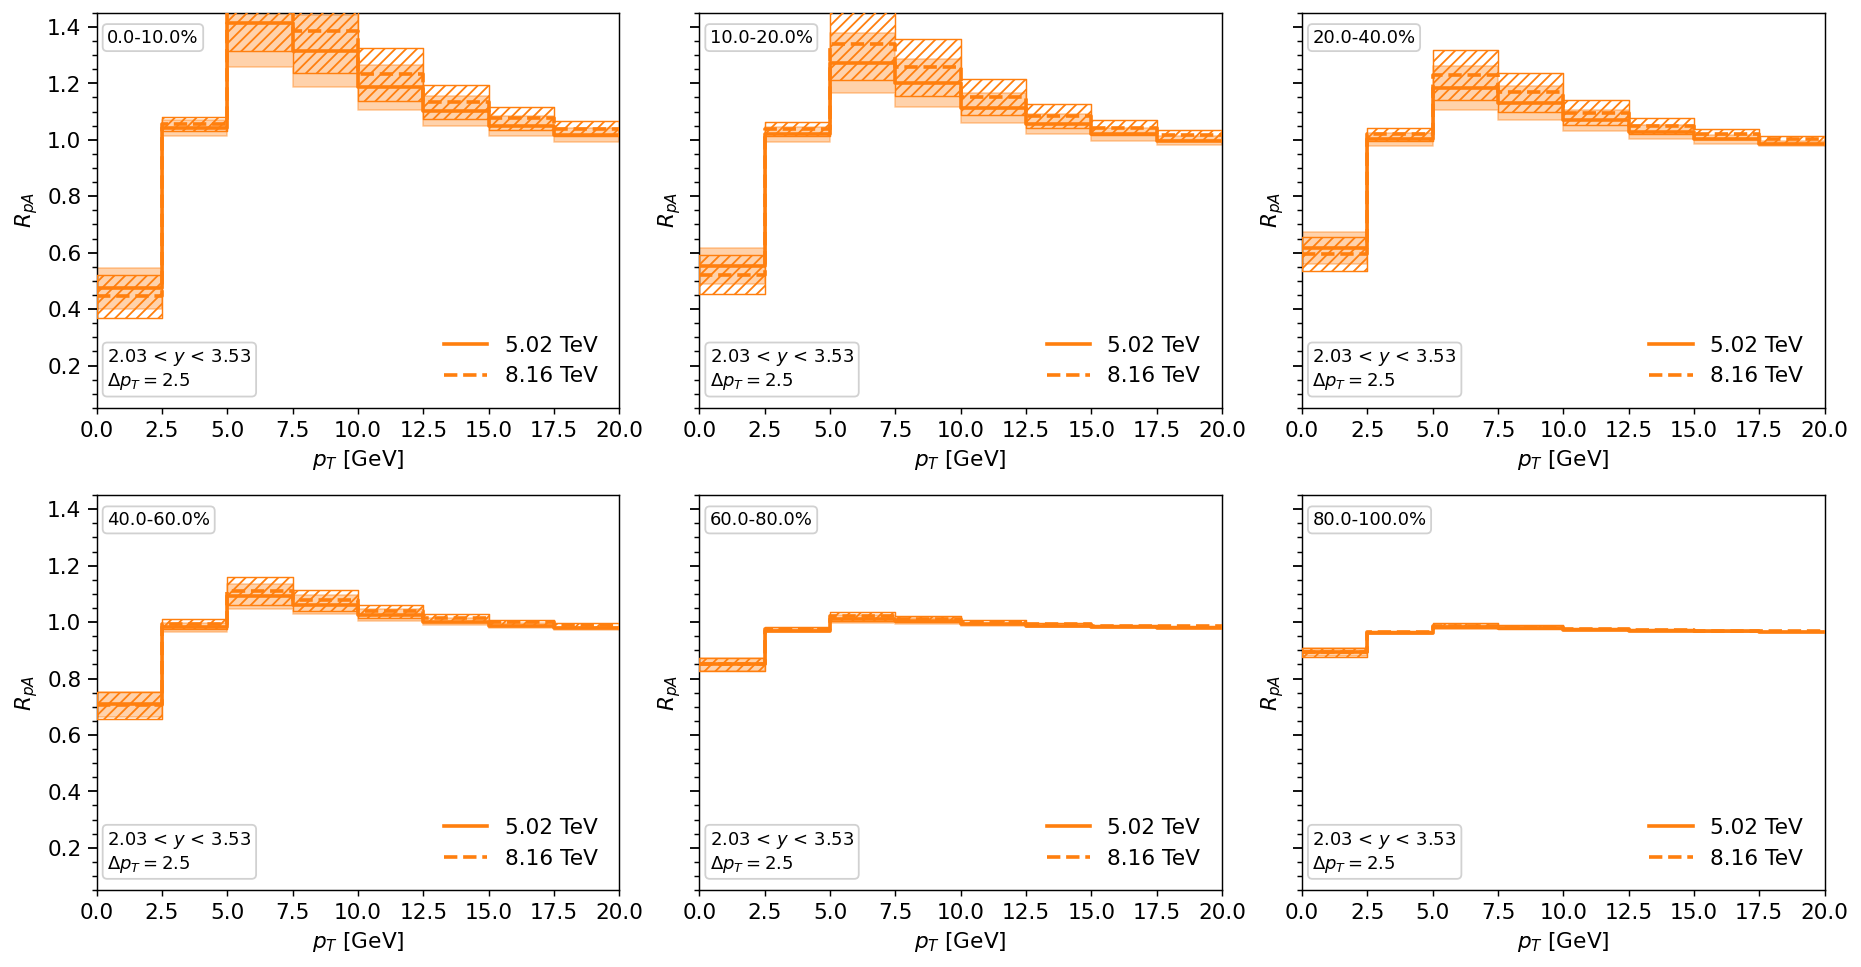

In [10]:
## Forward rapidity, pT dependence
eloss_rpa_vs_pt_in_centbins(
    run5=run5, run8=run8, cent_edges=CENT_EDGES,
    y_range=(2.03,3.53), pt_width=2.5,
    xlim=(0,20), ylim=(0.05,1.45), ncols=3,
    save=outdir/"eloss_RpA_vs_pT_in_centbins_FOR_5v8.pdf"
)

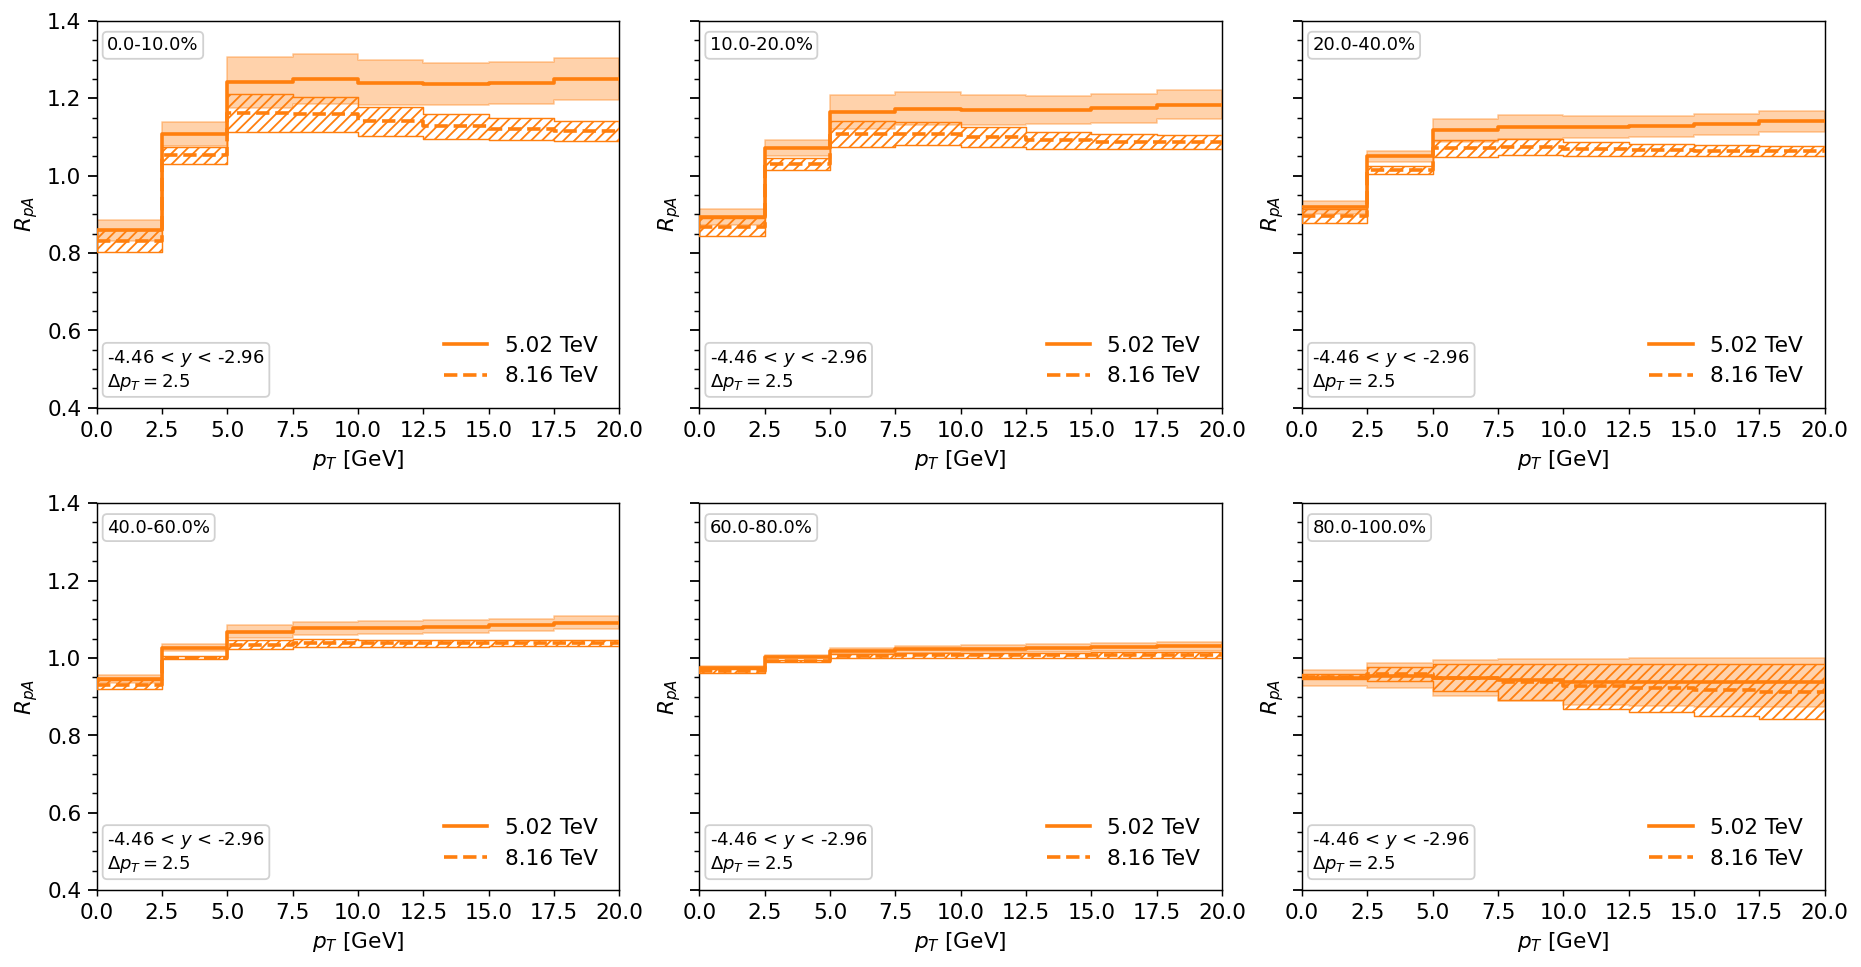

In [11]:
## Backward rapidity, pT dependence
eloss_rpa_vs_pt_in_centbins(
    run5=run5, run8=run8, cent_edges=CENT_EDGES,
    y_range=(-4.46,-2.96), pt_width=2.5,
    xlim=(0,20), ylim=(0.4,1.40), ncols=3,
    save=outdir/"eloss_RpA_vs_pT_in_centbins_BAC_5v8.pdf"
)

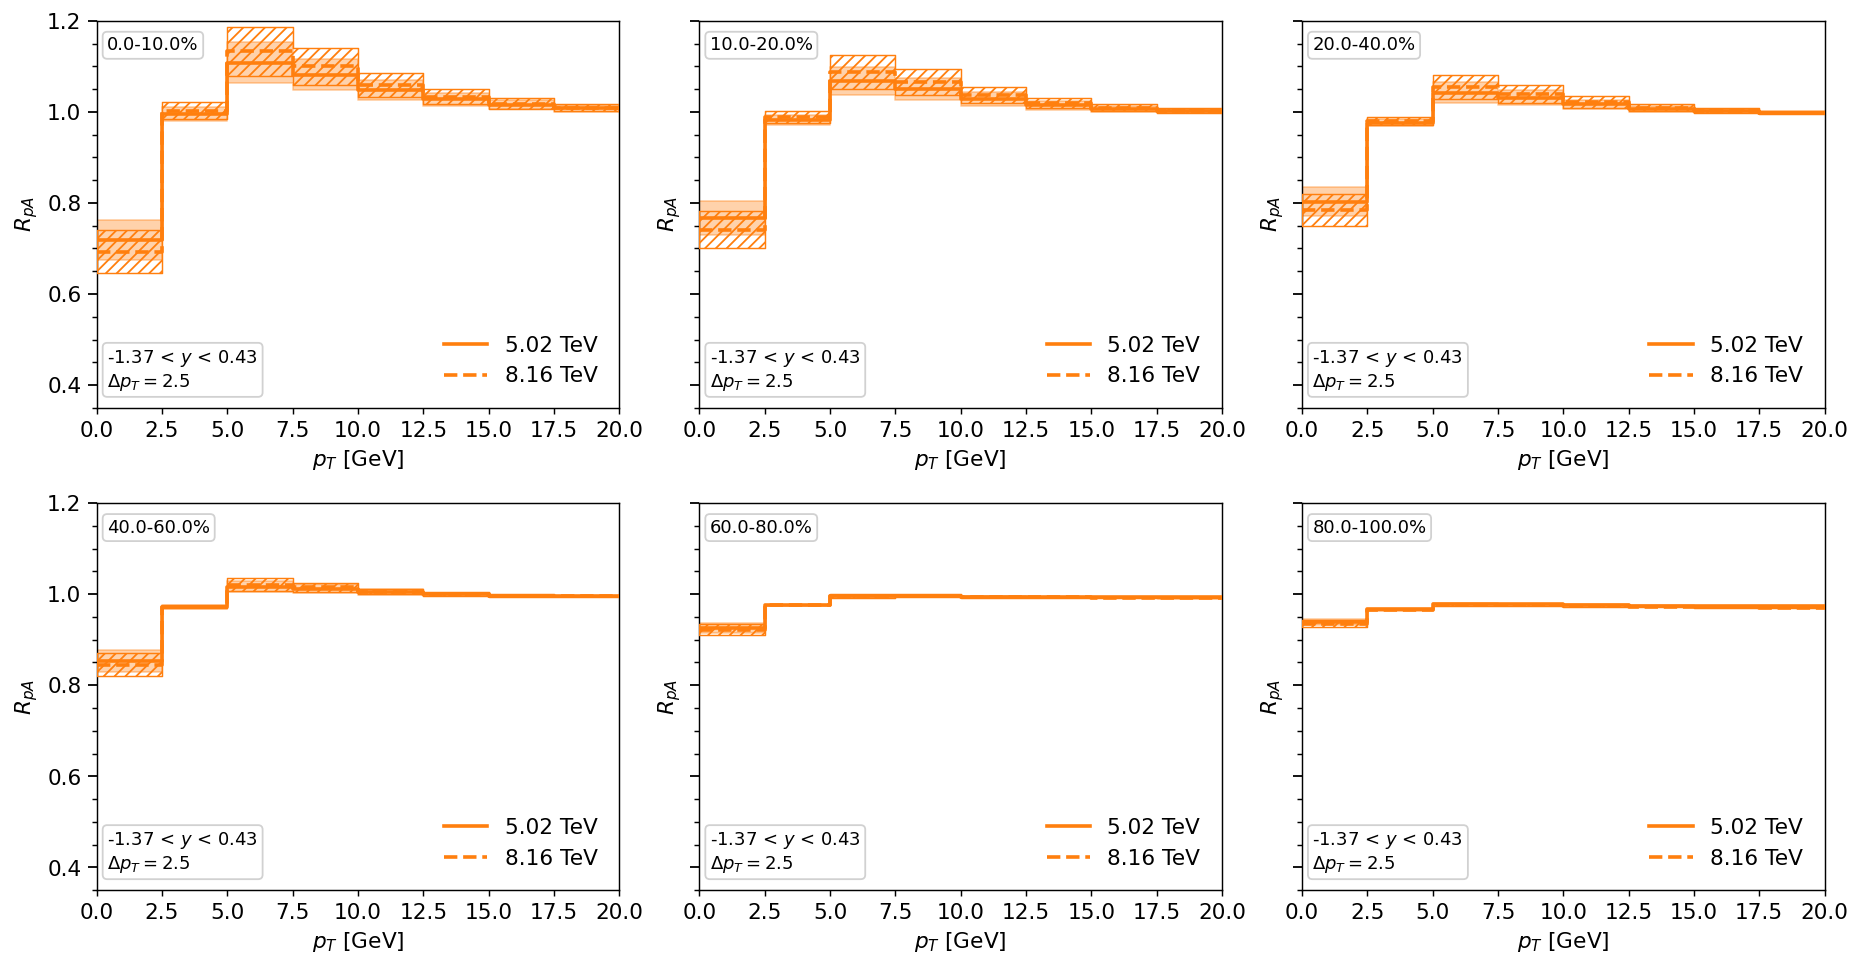

In [12]:
## Central rapidity, pT dependence
eloss_rpa_vs_pt_in_centbins(
    run5=run5, run8=run8, cent_edges=CENT_EDGES,
    y_range=(-1.37,0.43), pt_width=2.5,
    xlim=(0,20), ylim=(0.35,1.20), ncols=3,
    save=outdir/"eloss_RpA_vs_pT_in_centbins_CEN_5v8.pdf"
)